In [1]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing library**

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL#libraby to show image
import tensorflow as tf
%matplotlib inline
from tensorflow import keras
from keras import Sequential # because of it we don't have to write keras.Sequantial
from keras.layers import Dense, Dropout,Conv2D,Flatten, MaxPooling2D
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

**Unzippig the seg_pred, seg_test, sed_train files**

In [4]:
#seg_pred
import zipfile
import glob
from pathlib import Path
p=Path('/content/drive/MyDrive/dataset')
for files in p.glob('*.zip'):
  with zipfile.ZipFile(files,'r') as zipref:#making reference to particular zip file
    zipref.extractall('./*')#extracting all zip files
    #print(f'Done')
  zipref.close()#close zippref

In [5]:
train_dat="/content/*/seg_train"
train_dat= Path(train_dat)
test_dat="/content/*/seg_test"
test_dat= Path(test_dat)

In [6]:
type(test_dat)

pathlib.PosixPath

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dat,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


In [9]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(test_dat,
                                                             target_size=(150, 150),
                                                             batch_size=32,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


In [10]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


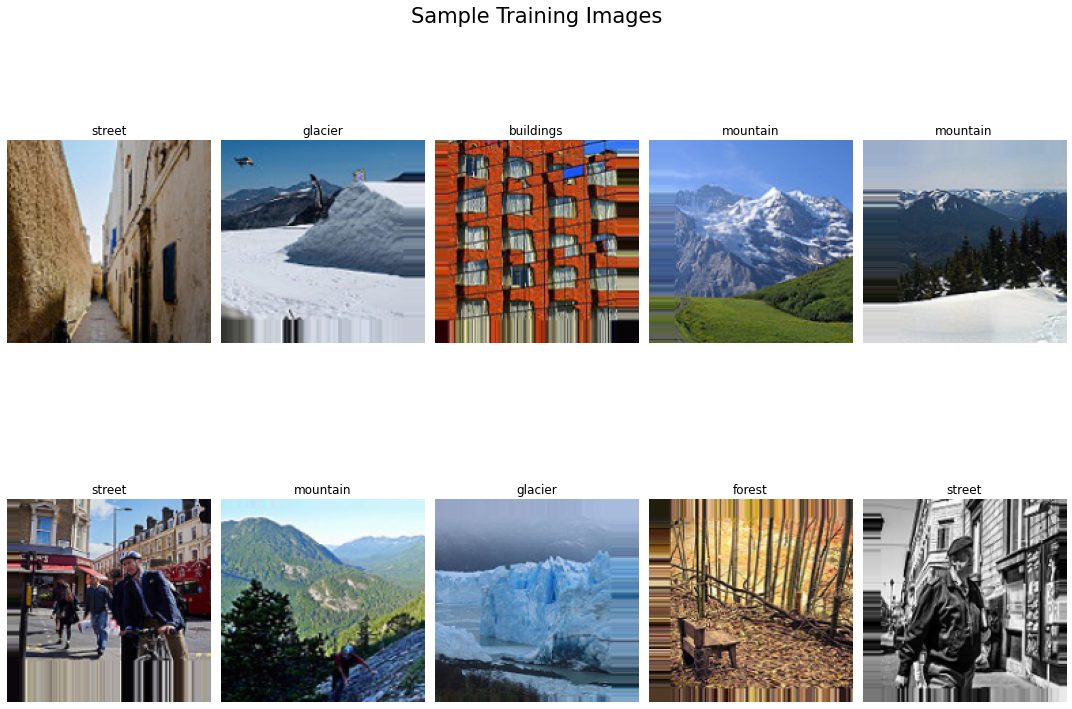

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
index = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][index])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][index][:, :, :])
        ax[i, j].axis("off")
        index += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

**Training CNN model using hyperparameyter**

In [12]:
import keras_tuner as kt


In [13]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [14]:
def build_model(hp):
  model = Sequential([
      #first Conv2d layer
  Conv2D(filters=hp.Int('conv2d_1_filter', min_value=32, max_value=128, step=8),
        kernel_size=5,
        activation='relu',
        input_shape=(150,150,3)),
        
      #maxpooling
  MaxPooling2D(),

      #second Conv2d layer

  Conv2D(filters=hp.Int('conv2d_2_filter', min_value=32, max_value=128, step=8),
        kernel_size=3,kernel_regularizer=l2(0.01),
        activation='relu'),
        
      #maxpooling
  MaxPooling2D(),
  
  Conv2D(filters=hp.Int('conv2d_3_filter', min_value=32, max_value=128, step=8),
         kernel_size=3,kernel_regularizer=l2(0.01),activation='relu'),
  MaxPooling2D(),
      #flattened layers
  Flatten(),

      #first hidden layer
  Dense(units=hp.Int('dense_1_units', min_value=64, max_value=128, step=16),
        activation='relu'),
  Dropout(hp.Choice("1_dense_dropout"+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])),

      #second hidden layer
  Dense(units=hp.Int('dense_2_units', min_value=64, max_value=128, step=16),
        activation='relu'),
  Dropout(hp.Choice("2_dense_dropout"+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])),
  
      #final output layer
  Dense(6, activation='softmax')])
    
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(hp_learning_rate),
                loss="CategoricalCrossentropy",
                metrics=['accuracy'])
  return model

In [15]:
tuner=kt.RandomSearch(build_model,
                      objective='val_loss',
                      max_trials=3,
                      directory='tuning',
                      project_name='version1')


In [ ]:
tuner.search(train_generator,epochs=10,validation_data=(validation_generator))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
72                |?                 |conv2d_1_filter
88                |?                 |conv2d_2_filter
56                |?                 |conv2d_3_filter
112               |?                 |dense_1_units
0.4               |?                 |1_dense_dropout1
112               |?                 |dense_2_units
0.7               |?                 |2_dense_dropout1
0.001             |?                 |learning_rate

Epoch 1/10
439/439 [==============================] - 1349s 3s/step - loss: 1.5846 - accuracy: 0.3950 - val_loss: 1.1001 - val_accuracy: 0.5750
Epoch 2/10
439/439 [==============================] - 1326s 3s/step - loss: 1.1871 - accuracy: 0.5358 - val_loss: 0.9850 - val_accuracy: 0.6233
Epoch 3/10
439/439 [==============================] - 1341s 3s/step - loss: 1.1080 - accuracy: 0.5730 - val_loss: 0.9577 - val_accuracy: 0.6183
Epoch 4/10
302/439 [===================>..........] - ETA: 

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
model=tuner.get_best_models(num_models=1)[0]

In [ ]:
model.fit(train_generator, batch_size=32, epochs=100,initial_epoch=5,validation_data=(validation_generator))